### Colorblindness Simulation

This notebook outlines a method for transforming an image such that it represents (approximately) how an individual with protanopia, deuteranopia, or tritanopia would see a given image. The method is described mathematically on the following page:

https://ixora.io/projects/colorblindness/color-blindness-simulation-research/

This site very nicely describes why each transformation takes a certain form, and discusses some issues with other simulators available.

I don't claim to understand all of the reasoning behind the derivation, though comparisons to other similar pieces of software give very good results. Most of the transformation is written using the linear algebra framework provided by `numpy`, making it reasonably optimized.

In [1]:
# Going to be using a lot of numpy linear algebra stuff for the
# transformations
import numpy as np

# This method is outlined in the following repo (adapted from UE4)
# https://github.com/botman99/ColorBlindSimulation
# which itself references:
# https://ixora.io/projects/colorblindness/color-blindness-simulation-research/
def colorblindTransform(sRGBImageMatrix, transformType):
    # Image dimensions should be: shape(imageMatrix) = (:,:,3)
    # transformType should be in ['original', 'protanopia', 'deuteranopia', 'tritanopia']
        
    # Here are all of the transformation matrices that we use
    # They are taken (mostly) from the link above
    
    # If I really wanted to optimize this, I should move these outside the function
    # since they are constant, but this notebook is just for testing
    
    # Transform to the "linear-light" (XYZ) space
    RGBtoXYZTransform = np.array([[.4124564, .3575761, .1804375],
                        [.2126729, .7151522, .0721750],
                        [.0193339, .1191920, .9503041]])
    
    # Transform to the Long, Medium, Short (LMS) color space
    # This uses the Hunt-Pointer-Estevez model
    XYZtoLMSTransform = np.array([[.4002, .7076, -.0808],
                                 [-.2263, 1.1653, .0457],
                                 [0, 0, .9182]])

    # Create a single operator to define both transformations
    RGBtoLMSTransform = np.dot(XYZtoLMSTransform, RGBtoXYZTransform)
    # And calculate the inverse transform to transform back after we modify the image
    LMStoRGBTransform = np.linalg.inv(RGBtoLMSTransform)
    #print(LMStoRGBTransform)

    # These are our specific color blindness matrices
    # Each on leaves two cones unmodified while transforming one
    
    # Protanopia - Missing L cones -
    protanopiaTransform = np.array([[0, 1.05118294, -.05116099],
                                   [0, 1., 0],
                                   [0, 0, 1.]])
    
    # Deuteranopia - Missing M cones
    deuteranopiaTransform = np.array([[1., 0, 0],
                                     [.9513092, 0, .04866992],
                                     [0, 0, 1.]])
    
    # Tritanopia - Missing S cones
    tritanopiaTransform = np.array([[1., 0, 0],
                                   [0, 1., 0],
                                   [-.86744736, 1.86727089, 0]])
    
    # Transform from standard RGB to linear RGB
    # 2.4 is the "gamma" value; if you want more information look that up (or check it out on one of the previous pages)
    # These lines are a bit of dozy, so I would definitely check over the part of the ixora.io page
    # about this
    linearRGBImageMatrix = np.zeros_like(sRGBImageMatrix, dtype='double')
    linearRGBImageMatrix[sRGBImageMatrix <= .04045*255] = sRGBImageMatrix[sRGBImageMatrix <= .04045*255]/(255.*12.92)
    linearRGBImageMatrix[sRGBImageMatrix > .04045*255] = pow((sRGBImageMatrix[sRGBImageMatrix > .04045*255]/255 + .055)/1.055, 2.4)
    #print(len(np.unique(linearRGBImageMatrix))) # Print the number of unique items
    
    #linearRGBImageMatrix = pow(abs(sRGBImageMatrix), 2.2)

    # Apply our transformations to the cone space
    # The notation to apply any of our transformations is a little more complicated than a dot product
    # since the operators have to be applied from the left
    # Normally this would be trivial and we could just switch the order of arguments np.dot() but since
    # our pixel arrays are a (N,M,3) tensor, it's not quite that easy. The solution is to use the
    # np.tensordot() function, which allows us to specify exactly how many axes to work along
    
    # Note that we work with the transposed image matrix while in LMS space
    # We could convert back and forth, but that would just use 3 extra transpose operations and slow down evaluation
    LMSImageMatrix = np.tensordot(RGBtoLMSTransform, np.transpose(linearRGBImageMatrix), axes=1)
    
    # Apply the request colorblindness transformation
    if transformType.lower() == "protanopia":
        LMSImageMatrix = np.tensordot(protanopiaTransform, LMSImageMatrix, axes=1)
    elif transformType.lower() == "deuteranopia":
        LMSImageMatrix = np.tensordot(deuteranopiaTransform, LMSImageMatrix, axes=1)
    elif transformType.lower() == "tritanopia":
        LMSImageMatrix = np.tensordot(tritanopiaTransform, LMSImageMatrix, axes=1)
    elif transformType.lower() == 'original':
        pass # This is here just so I can loop over the transformation for testing
    else:
        raise Exception(f'Unsupported transform provided: {transformType}')
        
    # Now transform back to linear RGB space
    linearRGBImageMatrix = np.transpose(np.tensordot(LMStoRGBTransform, LMSImageMatrix, axes=1))

    # And back to standard RGB
    # Again, check out the webpage listed above for more information on this operation
    editedImageMatrix = np.zeros_like(sRGBImageMatrix, dtype='int')
    editedImageMatrix[linearRGBImageMatrix <= .0031308] = 255 * 12.92 * linearRGBImageMatrix[linearRGBImageMatrix <= .0031308]
    editedImageMatrix[linearRGBImageMatrix > .0031308] = 255 * (1.055 * pow(linearRGBImageMatrix[linearRGBImageMatrix > .0031308], .41666) - .055)
    
    # Make sure there aren't any invalid pixel values
    editedImageMatrix[editedImageMatrix > 255] = 255
    editedImageMatrix[editedImageMatrix < 0] = 0

    return editedImageMatrix

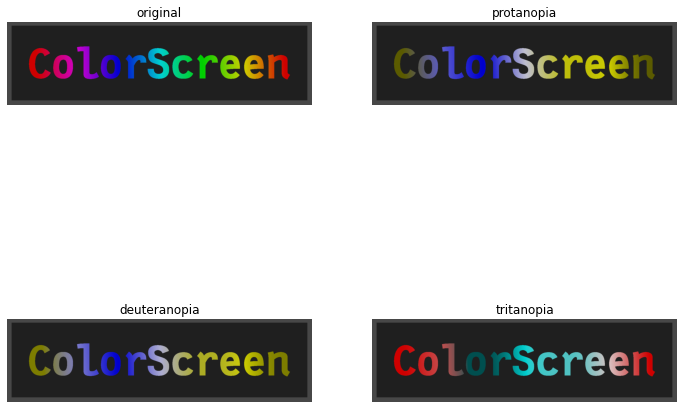

In [2]:
import matplotlib.pyplot as plt # Displaying images
from PIL import Image # Importing images 

# Open up our image (I have a few that I've been testing on; test.png is a color wheel)
image = np.array(Image.open('logo.png'))

# Some pngs have a 4th pixel value representing transparency
# We don't care about this, so we ignore it if it exists
if np.shape(image)[2] == 4:
    image = image[:,:,0:3]
    
# Plot all 4 possible transformations
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
transforms = ['original', 'protanopia', 'deuteranopia', 'tritanopia']

for i in range(4):
    transform = colorblindTransform(image, transforms[i])
    saveable = Image.fromarray(transform.astype(np.uint8))
    saveable.save(f'{transforms[i]}-logo.png')
    ax[int(i/2), i%2].imshow(transform)
    ax[int(i/2), i%2].axis('off')
    ax[int(i/2), i%2].set_title(transforms[i])
    
plt.show()